# Lab Assignment Five: Evaluation and Multi-Layer Perceptron
## Rupal Sanghavi, Omar Roa

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import make_scorer
from scipy.special import expit
import time
import math
from memory_profiler import memory_usage
from sklearn import metrics as mt


from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

target_classifier = 'Shopping centres'
df = pd.read_csv('responses.csv', sep=",")

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Preparation

In [2]:
# remove rows whose target classfier value is NaN
df_cleaned_classifier = df[np.isfinite(df[target_classifier])]
# change NaN number values to the mean
df_imputed = df_cleaned_classifier.fillna(df.mean())
# get categorical features
object_features = list(df_cleaned_classifier.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

# Evaluation

## Metrics To Evaluate Algorithm's Generalization Performance

In [3]:
# Research on Cost Matrix
# http://www.ibm.com/support/knowledgecenter/SSEPGG_11.1.0/com.ibm.im.model.doc/c_cost_matrix.html

cost_matrix = np.matrix([[0,1,2,3,4],
[1,0,1,2,3],
[3,1,0,1,2],
[5,3,1,0,1],
[7,5,2,1,0]])

def get_confusion_costTot(confusion_matrix, cost_matrix):
    score = np.sum(confusion_matrix*cost_matrix)
    return score

confusion_scorer = make_scorer(get_confusion_costTot, greater_is_better=False)
confusion_scorer

make_scorer(get_confusion_costTot, greater_is_better=False)

## Custom Implementation of Multi-Layer Perceptron

In [4]:
from sklearn.model_selection import StratifiedKFold

# we want to predict the X and y data as follows:
if target_classifier in df_fixed:
    y = df_fixed[target_classifier].values # get the label we want
    del df_fixed[target_classifier] # get rid of the class label
    X = df_fixed.values # use everything else to predict!

X = X/5
num_folds = 10

cv_object = StratifiedKFold(n_splits= num_folds, random_state=None, shuffle=True)
cv_object.split(X,y)

print(cv_object)

StratifiedKFold(n_splits=10, random_state=None, shuffle=True)


In [5]:
X

array([[ 1. ,  0.6,  0.4, ...,  0.2,  0.2,  0. ],
       [ 0.8,  0.8,  0.4, ...,  0. ,  0.2,  0. ],
       [ 1. ,  1. ,  0.4, ...,  0. ,  0.2,  0. ],
       ..., 
       [ 0.8,  0.6,  0.2, ...,  0. ,  0.2,  0. ],
       [ 1. ,  0.6,  0.6, ...,  0. ,  0.2,  0. ],
       [ 1. ,  1. ,  0.8, ...,  0.2,  0. ,  0.2]])

In [6]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, nonlinearity = "sigmoid"):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.nonlinearity = nonlinearity
        self.params = {}
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        if(self.nonlinearity == "sigmoid"):
            A2 = self._sigmoid(Z1)
            A2 = self._add_bias_unit(A2, how='row')
            Z2 = W2 @ A2
            A3 = self._sigmoid(Z2)
        else:
            A2 = Z1
            A2 = self._add_bias_unit(A2, how='row')
            Z2 = W2 @ A2
            A3 = Z2
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        if(self.nonlinearity == "sigmoid"):
            sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
            sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        else:
            sigma3 = -2*(Y_enc-A3)
            sigma2 = (W2.T @ sigma3)
            
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    def get_params(self,deep=False):
        return dict(n_hidden=self.n_hidden, C=self.l2_C, nonlinearity=self.nonlinearity)

    def set_params(self,**kwds):
        print(kwds)
        self.n_hidden = kwds['n_hidden']
        self.C = kwds['C']
        self.nonlinearity = kwds['nonlinearity']

In [7]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    

In [21]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = (A3-Y_enc) # <- this is only line that changed
        if(self.nonlinearity == "sigmoid"):
            sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        else:
            sigma2 = (W2.T @ sigma3)
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
        
    

In [22]:
class TLPDropoutQuad(TLPMiniBatch):
    def __init__(self, dropout=True, **kwds):        
        # need to add to the original initializer 
        self.dropout = dropout

        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            
            if self.dropout:
                # be sure to select the other half of the neurons each epoch
                if True :#i%2 == 0:
                    # randomly select half of the neurons
                    idx_dropout = np.random.permutation(W1.shape[0])
                    idx_other_half = idx_dropout[:int(W1.shape[0]/2)]
                    idx_dropout = idx_dropout[int(W1.shape[0]/2):] #drop half
                else:
                    # select the other half
                    idx_dropout = idx_other_half
                    
                idx_dropout = np.sort(idx_dropout)
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                W1 = W1[idx_dropout,:]# get rid of rows
                W2 = W2[:,idx_W2_withbias]# get rid of extra columns
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                
            
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       W1,
                                                       W2)
                
                cost = self._cost(A3,Y_enc[:, idx],W1,W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=W1,W2=W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout = delta_W1, delta_W2

            if self.dropout:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                self.W2[:,idx_W2_withbias] = W2
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                delta_W2_prev[:,idx_W2_withbias] = delta_W2_prev_dropout
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self

In [23]:

class TLPDropout(TLPMiniBatchCrossEntropy):
    def __init__(self, dropout=True, **kwds):        
        # need to add to the original initializer 
        self.dropout = dropout

        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            
            if self.dropout:
                # be sure to select the other half of the neurons each epoch
                if True :#i%2 == 0:
                    # randomly select half of the neurons
                    idx_dropout = np.random.permutation(W1.shape[0])
                    idx_other_half = idx_dropout[:int(W1.shape[0]/2)]
                    idx_dropout = idx_dropout[int(W1.shape[0]/2):] #drop half
                else:
                    # select the other half
                    idx_dropout = idx_other_half
                    
                idx_dropout = np.sort(idx_dropout)
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                W1 = W1[idx_dropout,:]# get rid of rows
                W2 = W2[:,idx_W2_withbias]# get rid of extra columns
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                
            
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       W1,
                                                       W2)
                
                cost = self._cost(A3,Y_enc[:, idx],W1,W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=W1,W2=W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout = delta_W1, delta_W2

            if self.dropout:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                self.W2[:,idx_W2_withbias] = W2
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                delta_W2_prev[:,idx_W2_withbias] = delta_W2_prev_dropout
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self

In [24]:
class TLPGaussianInitialQuad(TLPMiniBatch):             
    def _initialize_weights(self):
        """Initialize weights with smal l random numbers."""
        W1 = np.random.randn(self.n_hidden, self.n_features_ + 1)
        W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features_+1) # don't saturate the neuron
        
        W2 = np.random.randn(self.n_output_, self.n_hidden + 1)
        W2[:,1:] = W2[:,1:]/np.sqrt(self.n_hidden+1) # don't saturate the neuron
        return W1, W2

In [25]:
class TLPGaussianInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1 = np.random.randn(self.n_hidden, self.n_features_ + 1)
        W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features_+1) # don't saturate the neuron
        
        W2 = np.random.randn(self.n_output_, self.n_hidden + 1)
        W2[:,1:] = W2[:,1:]/np.sqrt(self.n_hidden+1) # don't saturate the neuron
        return W1, W2

In [26]:
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':75, 'eta':0.001, 
         'alpha':0.0, 'decrease_const':1e-9, 'minibatches':200,
         'shuffle':True,'random_state':1, 'dropout':False}

In [27]:
class TLPReLu(TLPDropout):
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        # Glorot, Xavier, Antoine Bordes, and Yoshua Bengio. 
        #   "Deep Sparse Rectifier Neural Networks."
        init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))

        init_bound = np.sqrt(2. / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1))
        return W1, W2
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
        
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->Sigmoid
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = (A3-Y_enc) 
        # sigma3[Z2<=0] = 0 # can change to be relu back prop on this layer too!
        
        sigma2 = (W2.T @ sigma3) 
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        sigma2[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    


In [28]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

In [29]:
with np.errstate(all='ignore'):

    nonlinearities = ["sigmoid","linear"]
    costs = ['quadratic','cross']
    
    custom_performances = []
    lowest_score = 10000
    best_cost = ""
    best_nonlin = ""
for cost in costs:
    for nonlinearity in nonlinearities:

        vals = {'n_hidden':50, 
                     'C':1e-2, 'epochs':75, 'eta':0.001, 
                     'alpha':0.0, 'decrease_const':1e-9, 'minibatches':200,
                     'shuffle':True,'random_state':1, 
                       'nonlinearity': nonlinearity}
        for train_indices, test_indices in cv_object.split(X,y): 
                    print("---------------------------------")
                    print("")
                    print(cost)
                    print(nonlinearity)
                    # I will create new variables here so that it is more obvious what 
                    # the code is doing (you can compact this syntax and avoid duplicating memory,
                    # but it makes this code less readable)
                    X_train = (X[train_indices])
                    y_train = y[train_indices]

                    X_test = (X[test_indices])
                    y_test = y[test_indices]
                    
                    if(cost == "quadratic"):
                        nn_long_sigmoid = TLPGaussianInitialQuad(**vals)
                    else:
                        print("in")
                        nn_long_sigmoid = TLPGaussianInitial(**vals)

                    #%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
                    %time nn_long_sigmoid.fit(X_train, y_train, print_progress=1)
                    y_hat = nn_long_sigmoid.predict(X_test) # get test set precitions

                    # now let's get the accuracy and confusion matrix for this iterations of training/testing
                    acc = mt.accuracy_score(y_test,y_hat+1)
            #         lr_clf_accuracies.append(acc)
            #         cost_accuracies.append([acc])

                    conf = mt.confusion_matrix(y_test,y_hat+1)
        #             print(vals)
#                     print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")
#                     plt.show()
                    print("confusion matrix\n",conf)
                    score = get_confusion_costTot(conf, cost_matrix)
                    print("Weighted Confusion Matrix Score: ", score)
                    custom_performances.append(score)
                    if(score < lowest_score): 
                        lowest_score=score
                        best_cost=cost
                        best_nonlin=nonlinearity

print("---------------------------------")

print("Best Score: ",lowest_score)               
print("Best cost: ",best_cost)
print("Best Non-Linearity: ",best_nonlin)


Epoch: 4/75

---------------------------------

quadratic
sigmoid


Epoch: 4/75

CPU times: user 15 s, sys: 346 ms, total: 15.4 s
Wall time: 3.9 s
confusion matrix
 [[ 0  0  7  0  7]
 [ 0  0 11  0  7]
 [ 0  0 11  1 13]
 [ 0  0  9  0 15]
 [ 0  0  7  0 15]]
Weighted Confusion Matrix Score:  1180
---------------------------------

quadratic
sigmoid


Epoch: 4/75

CPU times: user 15.2 s, sys: 313 ms, total: 15.5 s
Wall time: 3.93 s
confusion matrix
 [[ 0  0 13  0  1]
 [ 0  0 18  0  0]
 [ 0  0 24  0  1]
 [ 0  0 18  3  3]
 [ 0  0 10  2 10]]
Weighted Confusion Matrix Score:  856
---------------------------------

quadratic
sigmoid


Epoch: 4/75

CPU times: user 15.2 s, sys: 306 ms, total: 15.5 s
Wall time: 3.91 s
confusion matrix
 [[ 0  0  5  1  7]
 [ 0  0  2  1 15]
 [ 0  0  7  0 18]
 [ 0  0  2  3 19]
 [ 0  0  1  0 21]]
Weighted Confusion Matrix Score:  1369
---------------------------------

quadratic
sigmoid


Epoch: 5/75

CPU times: user 14.4 s, sys: 227 ms, total: 14.6 s
Wall time: 3.68 s
confusion matrix
 [[ 0  0  7  6  0]
 [ 0  0 12  6  0]
 [ 0  0  7 15  2]
 [ 0  0  8 14  2]
 [ 0  0  4 13  5]]
Weighted Confusion Matrix Score:  941
---------------------------------

quadratic
sigmoid


Epoch: 5/75

CPU times: user 14.9 s, sys: 345 ms, total: 15.3 s
Wall time: 3.93 s
confusion matrix
 [[ 0  0  7  6  0]
 [ 0  0 13  4  1]
 [ 0  0 14  8  2]
 [ 0  0 16  5  3]
 [ 0  0 12  6  4]]
Weighted Confusion Matrix Score:  874
---------------------------------

quadratic
sigmoid


Epoch: 5/75

CPU times: user 13.7 s, sys: 173 ms, total: 13.9 s
Wall time: 3.49 s
confusion matrix
 [[ 0  1  5  0  7]
 [ 0  0  6  4  8]
 [ 0  0  4  4 16]
 [ 0  0  1  4 19]
 [ 0  0  1  2 19]]
Weighted Confusion Matrix Score:  1301
---------------------------------

quadratic
sigmoid


Epoch: 4/75

CPU times: user 13.8 s, sys: 177 ms, total: 14 s
Wall time: 3.51 s
confusion matrix
 [[ 0  0 12  0  1]
 [ 0  0 15  0  2]
 [ 0  0 19  0  5]
 [ 0  0 14  0 10]
 [ 0  0  9  0 13]]
Weighted Confusion Matrix Score:  948
---------------------------------

quadratic
sigmoid


Epoch: 4/75

CPU times: user 15.9 s, sys: 337 ms, total: 16.3 s
Wall time: 4.14 s
confusion matrix
 [[ 0  0 11  0  2]
 [ 0  0 11  1  5]
 [ 0  0 12  2 10]
 [ 0  1  8  3 12]
 [ 0  0  6  2 14]]
Weighted Confusion Matrix Score:  1068
---------------------------------

quadratic
sigmoid


Epoch: 4/75

CPU times: user 16.8 s, sys: 384 ms, total: 17.2 s
Wall time: 4.4 s
confusion matrix
 [[ 0  0 10  2  1]
 [ 0  0 14  3  0]
 [ 0  0 15  6  3]
 [ 0  1 11  7  4]
 [ 0  0  9  8  5]]
Weighted Confusion Matrix Score:  875
---------------------------------

quadratic
sigmoid


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.8 s, sys: 443 ms, total: 17.3 s
Wall time: 4.4 s
confusion matrix
 [[ 0  0  6  3  4]
 [ 0  0  9  4  4]
 [ 0  0  7  6 11]
 [ 0  0  4  5 14]
 [ 0  0  1  8 12]]
Weighted Confusion Matrix Score:  1124
---------------------------------

quadratic
linear


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 5/75

CPU times: user 15.5 s, sys: 355 ms, total: 15.9 s
Wall time: 4.03 s
confusion matrix
 [[14  0  0  0  0]
 [18  0  0  0  0]
 [25  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1030
---------------------------------

quadratic
linear


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 15.3 s, sys: 383 ms, total: 15.7 s
Wall time: 4 s
confusion matrix
 [[14  0  0  0  0]
 [18  0  0  0  0]
 [25  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1030
---------------------------------

quadratic
linear


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16 s, sys: 422 ms, total: 16.5 s
Wall time: 4.21 s
confusion matrix
 [[13  0  0  0  0]
 [18  0  0  0  0]
 [25  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

quadratic
linear


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.1 s, sys: 440 ms, total: 16.5 s
Wall time: 4.22 s
confusion matrix
 [[13  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1010
---------------------------------

quadratic
linear


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.4 s, sys: 459 ms, total: 16.9 s
Wall time: 4.32 s
confusion matrix
 [[13  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1010
---------------------------------

quadratic
linear


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 5/75

CPU times: user 14.3 s, sys: 227 ms, total: 14.6 s
Wall time: 3.67 s
confusion matrix
 [[13  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1010
---------------------------------

quadratic
linear


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 13.9 s, sys: 185 ms, total: 14.1 s
Wall time: 3.53 s
confusion matrix
 [[13  0  0  0  0]
 [17  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1000
---------------------------------

quadratic
linear


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 5/75

CPU times: user 14.3 s, sys: 224 ms, total: 14.5 s
Wall time: 3.66 s
confusion matrix
 [[13  0  0  0  0]
 [17  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1000
---------------------------------

quadratic
linear


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 5/75

CPU times: user 13.5 s, sys: 131 ms, total: 13.6 s
Wall time: 3.41 s
confusion matrix
 [[13  0  0  0  0]
 [17  0  0  0  0]
 [24  0  0  0  0]
 [23  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  990
---------------------------------

quadratic
linear


Epoch: 3/75

CPU times: user 14 s, sys: 208 ms, total: 14.2 s
Wall time: 3.56 s
confusion matrix
 [[13  0  0  0  0]
 [17  0  0  0  0]
 [24  0  0  0  0]
 [23  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  980
---------------------------------

cross
sigmoid
in


Epoch: 4/75

CPU times: user 17.7 s, sys: 277 ms, total: 17.9 s
Wall time: 4.52 s
confusion matrix
 [[ 0 11  3  0  0]
 [ 0 13  4  1  0]
 [ 0 16  6  2  1]
 [ 0  8 11  3  2]
 [ 0  2  3 11  6]]
Weighted Confusion Matrix Score:  844
---------------------------------

cross
sigmoid
in


Epoch: 4/75

CPU times: user 17.4 s, sys: 242 ms, total: 17.6 s
Wall time: 4.43 s
confusion matrix
 [[ 0  0  9  1  4]
 [ 0  0  9  3  6]
 [ 0  0  3  4 18]
 [ 0  0  0  1 23]
 [ 0  0  0  1 21]]
Weighted Confusion Matrix Score:  1327
---------------------------------

cross
sigmoid
in


Epoch: 4/75

CPU times: user 17.2 s, sys: 219 ms, total: 17.4 s
Wall time: 4.37 s
confusion matrix
 [[ 0  1  8  0  4]
 [ 0  0  7  0 11]
 [ 0  0  8  0 17]
 [ 0  0  3  0 21]
 [ 0  0  0  0 22]]
Weighted Confusion Matrix Score:  1314
---------------------------------

cross
sigmoid
in


Epoch: 4/75

CPU times: user 17.8 s, sys: 272 ms, total: 18 s
Wall time: 4.54 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 15  1  2]
 [ 0  0 17  0  7]
 [ 0  0 11  0 13]
 [ 0  0  8  0 14]]
Weighted Confusion Matrix Score:  998
---------------------------------

cross
sigmoid
in


Epoch: 4/75

CPU times: user 17.8 s, sys: 303 ms, total: 18.1 s
Wall time: 4.57 s
confusion matrix
 [[ 0  0  0  4  9]
 [ 0  0  0  4 14]
 [ 0  0  0  7 17]
 [ 0  0  0  0 24]
 [ 0  0  0  1 21]]
Weighted Confusion Matrix Score:  1435
---------------------------------

cross
sigmoid
in


Epoch: 4/75

CPU times: user 20.7 s, sys: 517 ms, total: 21.2 s
Wall time: 5.39 s
confusion matrix
 [[ 1  0  5  6  1]
 [ 1  0  9  8  0]
 [ 0  0  1 17  6]
 [ 0  0  0 12 12]
 [ 0  0  0  7 15]]
Weighted Confusion Matrix Score:  1135
---------------------------------

cross
sigmoid
in


Epoch: 3/75

CPU times: user 19.8 s, sys: 500 ms, total: 20.3 s
Wall time: 5.16 s
confusion matrix
 [[ 0  4  7  0  2]
 [ 0  1 10  1  5]
 [ 0  0 16  0  8]
 [ 0  0 14  1  9]
 [ 0  0  5  1 16]]
Weighted Confusion Matrix Score:  1029
---------------------------------

cross
sigmoid
in


Epoch: 4/75

CPU times: user 20.4 s, sys: 504 ms, total: 20.9 s
Wall time: 5.32 s
confusion matrix
 [[ 0  4  3  4  2]
 [ 0  3  3  5  6]
 [ 0  1  3 13  7]
 [ 0  0  3  7 14]
 [ 0  0  1  1 20]]
Weighted Confusion Matrix Score:  1182
---------------------------------

cross
sigmoid
in


Epoch: 4/75

CPU times: user 18.8 s, sys: 431 ms, total: 19.2 s
Wall time: 4.88 s
confusion matrix
 [[ 6  0  7  0  0]
 [ 4  0 12  0  1]
 [ 1  0 10  0 13]
 [ 0  0 10  1 12]
 [ 0  0  5  0 17]]
Weighted Confusion Matrix Score:  1073
---------------------------------

cross
sigmoid
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 18.3 s, sys: 332 ms, total: 18.6 s
Wall time: 4.7 s
confusion matrix
 [[ 0  5  6  2  0]
 [ 0  0 14  1  2]
 [ 0  0 19  1  4]
 [ 0  1  7  4 11]
 [ 0  1  4  1 15]]
Weighted Confusion Matrix Score:  969
---------------------------------

cross
linear
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.7 s, sys: 277 ms, total: 17 s
Wall time: 4.29 s
confusion matrix
 [[14  0  0  0  0]
 [18  0  0  0  0]
 [25  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1030
---------------------------------

cross
linear
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.4 s, sys: 268 ms, total: 16.7 s
Wall time: 4.21 s
confusion matrix
 [[14  0  0  0  0]
 [18  0  0  0  0]
 [25  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1030
---------------------------------

cross
linear
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.3 s, sys: 280 ms, total: 16.6 s
Wall time: 4.18 s
confusion matrix
 [[13  0  0  0  0]
 [18  0  0  0  0]
 [25  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

cross
linear
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.4 s, sys: 221 ms, total: 16.6 s
Wall time: 4.16 s
confusion matrix
 [[13  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1010
---------------------------------

cross
linear
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.4 s, sys: 279 ms, total: 16.7 s
Wall time: 4.22 s
confusion matrix
 [[13  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1010
---------------------------------

cross
linear
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.6 s, sys: 255 ms, total: 16.9 s
Wall time: 4.25 s
confusion matrix
 [[13  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1010
---------------------------------

cross
linear
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 16.1 s, sys: 228 ms, total: 16.4 s
Wall time: 4.11 s
confusion matrix
 [[13  0  0  0  0]
 [17  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1000
---------------------------------

cross
linear
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 3/75

CPU times: user 17.2 s, sys: 391 ms, total: 17.6 s
Wall time: 4.46 s
confusion matrix
 [[13  0  0  0  0]
 [17  0  0  0  0]
 [24  0  0  0  0]
 [24  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  1000
---------------------------------

cross
linear
in


Epoch: 1/75/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 4/75

CPU times: user 17.1 s, sys: 283 ms, total: 17.3 s
Wall time: 4.37 s
confusion matrix
 [[13  0  0  0  0]
 [17  0  0  0  0]
 [24  0  0  0  0]
 [23  0  0  0  0]
 [22  0  0  0  0]]
Weighted Confusion Matrix Score:  990
---------------------------------

cross
linear
in


Epoch: 75/75

CPU times: user 19 s, sys: 560 ms, total: 19.6 s
Wall time: 5.03 s
confusion matrix
 [[13  0  0  0  0]
 [17  0  0  0  0]
 [24  0  0  0  0]
 [23  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  980
---------------------------------
Best Score:  844
Best cost:  cross
Best Non-Linearity:  sigmoid


## Tuning the hyper-parameters

In [30]:
hidden_neurons = np.linspace(150, 200, num=10)
hidden_neurons.sort()

costs = np.logspace(-3,1, num=10)
costs.sort()

nonlinearities = ["sigmoid","linear"]

In [ ]:
with np.errstate(all='ignore'):
    param_grid_input = {'n_hidden': hidden_neurons, 'C': costs, 'nonlinearity' : nonlinearities}
    gscv = GridSearchCV(cv= cv_object, estimator=nn_long_sigmoid, param_grid= param_grid_input, scoring= confusion_scorer,refit=False)
    gscv.fit(X,y)

In [56]:
hidden_neurons = np.linspace(150, 200, num=10)
hidden_neurons.sort()

In [42]:
neuron_perf = []
for neurons in hidden_neurons:

        vals = {'n_hidden':neurons, 
                     'C':1e-2, 'epochs':75, 'eta':0.001, 
                     'alpha':0.0, 'decrease_const':1e-9, 'minibatches':200,
                     'shuffle':True,'random_state':1, 
                       'nonlinearity': "sigmoid"}
        for train_indices, test_indices in cv_object.split(X,y): 
                    print("---------------------------------")

                    X_train = (X[train_indices])
                    y_train = y[train_indices]

                    X_test = (X[test_indices])
                    y_test = y[test_indices]
                    
                    nn_long_sigmoid = TLPGaussianInitial(**vals)

                    #%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
                    %time nn_long_sigmoid.fit(X_train, y_train, print_progress=1)
                    y_hat = nn_long_sigmoid.predict(X_test) # get test set precitions

                    # now let's get the accuracy and confusion matrix for this iterations of training/testing
                    acc = mt.accuracy_score(y_test,y_hat+1)
            #         lr_clf_accuracies.append(acc)
            #         cost_accuracies.append([acc])

                    conf = mt.confusion_matrix(y_test,y_hat+1)
        #             print(vals)
#                     print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")
#                     plt.show()
                    print("confusion matrix\n",conf)
                    score = get_confusion_costTot(conf, cost_matrix)
                    print("Weighted Confusion Matrix Score: ", score)
                    neuron_perf.append(score)



/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 5.64 s, sys: 128 ms, total: 5.77 s
Wall time: 1.47 s
confusion matrix
 [[ 0  0  0 14  0]
 [ 0  0  1 17  0]
 [ 0  0  1 24  0]
 [ 0  0  1 23  0]
 [ 0  0  0 22  0]]
Weighted Confusion Matrix Score:  1021
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.38 s, sys: 81.4 ms, total: 5.46 s
Wall time: 1.37 s
confusion matrix
 [[ 0  1 13  0  0]
 [ 0  0 16  0  2]
 [ 0  0 24  0  1]
 [ 0  0 22  0  2]
 [ 0  0 19  0  3]]
Weighted Confusion Matrix Score:  785
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 5.66 s, sys: 122 ms, total: 5.78 s
Wall time: 1.47 s
confusion matrix
 [[ 0  0  9  0  4]
 [ 0  0  7  0 11]
 [ 0  0 11  0 14]
 [ 0  0  5  0 19]
 [ 0  0  7  0 15]]
Weighted Confusion Matrix Score:  1218
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.94 s, sys: 139 ms, total: 6.08 s
Wall time: 1.54 s
confusion matrix
 [[ 0  0  8  5  0]
 [ 0  0 10  8  0]
 [ 0  0 13 10  1]
 [ 0  0 10 13  1]
 [ 0  0  9  9  4]]
Weighted Confusion Matrix Score:  890
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.56 s, sys: 120 ms, total: 5.68 s
Wall time: 1.44 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 17  1  0]
 [ 0  0 22  0  2]
 [ 0  0 22  0  2]
 [ 0  0 20  0  2]]
Weighted Confusion Matrix Score:  758
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.8 s, sys: 114 ms, total: 5.91 s
Wall time: 1.49 s
confusion matrix
 [[ 0  5  1  7  0]
 [ 0  6  7  5  0]
 [ 0  6  5 13  0]
 [ 0  3  2 19  0]
 [ 0  3  1 17  1]]
Weighted Confusion Matrix Score:  898
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.63 s, sys: 116 ms, total: 5.74 s
Wall time: 1.45 s
confusion matrix
 [[ 0  0  3  0 10]
 [ 0  0  7  0 10]
 [ 0  0  3  0 21]
 [ 0  0  3  0 21]
 [ 0  0  1  0 21]]
Weighted Confusion Matrix Score:  1364
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 5.74 s, sys: 124 ms, total: 5.86 s
Wall time: 1.49 s
confusion matrix
 [[ 0  0  6  7  0]
 [ 0  0  9  8  0]
 [ 0  0 11 13  0]
 [ 0  0 12 12  0]
 [ 0  0  8 14  0]]
Weighted Confusion Matrix Score:  862
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 5.9 s, sys: 148 ms, total: 6.05 s
Wall time: 1.54 s
confusion matrix
 [[ 0  0  3  2  8]
 [ 0  0  3  3 11]
 [ 0  0  3  2 19]
 [ 0  0  2  0 21]
 [ 0  0  0  0 22]]
Weighted Confusion Matrix Score:  1362
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 5.88 s, sys: 161 ms, total: 6.04 s
Wall time: 1.54 s
confusion matrix
 [[ 0  0  0 13  0]
 [ 0  0  0 17  0]
 [ 0  0  0 24  0]
 [ 0  0  0 23  0]
 [ 0  0  0 21  0]]
Weighted Confusion Matrix Score:  980
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 6.03 s, sys: 186 ms, total: 6.21 s
Wall time: 1.59 s
confusion matrix
 [[ 0 11  0  3  0]
 [ 0 10  0  8  0]
 [ 0  9  0 16  0]
 [ 0 12  0 12  0]
 [ 0  8  0 14  0]]
Weighted Confusion Matrix Score:  880
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.77 s, sys: 89.1 ms, total: 5.86 s
Wall time: 1.47 s
confusion matrix
 [[ 0  0 14  0  0]
 [ 0  0 18  0  0]
 [ 0  0 25  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  721
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.01 s, sys: 106 ms, total: 6.11 s
Wall time: 1.57 s
confusion matrix
 [[ 0  0  7  6  0]
 [ 0  0  7 11  0]
 [ 0  0  9 16  0]
 [ 0  0  8 16  0]
 [ 0  0  2 20  0]]
Weighted Confusion Matrix Score:  921
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 6.21 s, sys: 155 ms, total: 6.36 s
Wall time: 1.62 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 14  0  4]
 [ 0  0 19  0  5]
 [ 0  0  9  0 15]
 [ 0  0 10  0 12]]
Weighted Confusion Matrix Score:  995
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 5.98 s, sys: 106 ms, total: 6.09 s
Wall time: 1.54 s
confusion matrix
 [[ 0  0  6  4  3]
 [ 0  0  8  5  5]
 [ 0  0 10  2 12]
 [ 0  0  5  8 11]
 [ 0  0  5  3 14]]
Weighted Confusion Matrix Score:  1133
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.78 s, sys: 87 ms, total: 5.87 s
Wall time: 1.47 s
confusion matrix
 [[ 0  0  8  4  1]
 [ 0  0 11  4  3]
 [ 0  0 13  4  7]
 [ 0  0 12  5  7]
 [ 0  0  5  5 12]]
Weighted Confusion Matrix Score:  1013
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.59 s, sys: 75.7 ms, total: 5.67 s
Wall time: 1.42 s
confusion matrix
 [[ 0  0  0 13  0]
 [ 0  0  0 17  0]
 [ 0  0  0 24  0]
 [ 0  0  0 24  0]
 [ 0  0  0 22  0]]
Weighted Confusion Matrix Score:  1000
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.64 s, sys: 72.2 ms, total: 5.71 s
Wall time: 1.43 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 17  0  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  700
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 3/15

CPU times: user 5.67 s, sys: 65.6 ms, total: 5.73 s
Wall time: 1.44 s
confusion matrix
 [[ 0  7  0  5  1]
 [ 0 14  0  3  0]
 [ 0 14  0 10  0]
 [ 0 17  0  6  0]
 [ 0  6  0 14  2]]
Weighted Confusion Matrix Score:  831
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 5.71 s, sys: 77.6 ms, total: 5.78 s
Wall time: 1.45 s
confusion matrix
 [[ 0  0  2 11  0]
 [ 0  0  4 13  0]
 [ 0  0  4 20  0]
 [ 0  0  1 22  0]
 [ 0  0  1 20  0]]
Weighted Confusion Matrix Score:  944
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.23 s, sys: 103 ms, total: 6.33 s
Wall time: 1.59 s
confusion matrix
 [[ 0  0 13  1  0]
 [ 0  0 18  0  0]
 [ 0  0 24  1  0]
 [ 0  0 21  3  0]
 [ 0  0 18  3  1]]
Weighted Confusion Matrix Score:  753
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.21 s, sys: 81.4 ms, total: 6.29 s
Wall time: 1.58 s
confusion matrix
 [[ 0  0  3 11  0]
 [ 0  0  3 15  0]
 [ 0  0  4 21  0]
 [ 0  0  4 20  0]
 [ 0  0  2 20  0]]
Weighted Confusion Matrix Score:  982
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.28 s, sys: 89 ms, total: 6.36 s
Wall time: 1.6 s
confusion matrix
 [[ 0  0 11  2  0]
 [ 0  0 16  1  1]
 [ 0  0 19  2  4]
 [ 0  0 16  2  6]
 [ 0  0 14  5  3]]
Weighted Confusion Matrix Score:  862
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.32 s, sys: 74.9 ms, total: 6.4 s
Wall time: 1.6 s
confusion matrix
 [[ 0  0  2  0 11]
 [ 0  0  0  0 18]
 [ 0  2  2  0 20]
 [ 0  0  1  0 23]
 [ 0  0  0  0 22]]
Weighted Confusion Matrix Score:  1459
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.32 s, sys: 83 ms, total: 6.4 s
Wall time: 1.61 s
confusion matrix
 [[ 0  0  1 12  0]
 [ 0  0  1 17  0]
 [ 0  0  0 23  1]
 [ 0  0  1 22  1]
 [ 0  0  0 21  1]]
Weighted Confusion Matrix Score:  1016
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.38 s, sys: 83.4 ms, total: 6.47 s
Wall time: 1.62 s
confusion matrix
 [[ 0  0  2  0 11]
 [ 0  0  1  0 17]
 [ 0  0  3  0 21]
 [ 0  0  2  0 22]
 [ 0  0  0  0 22]]
Weighted Confusion Matrix Score:  1451
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.32 s, sys: 85.2 ms, total: 6.4 s
Wall time: 1.61 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 17  0  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  700
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.37 s, sys: 85.8 ms, total: 6.45 s
Wall time: 1.62 s
confusion matrix
 [[ 0  0  5  7  1]
 [ 0  0  5 10  2]
 [ 0  0  4 16  4]
 [ 0  0  0 18  6]
 [ 0  0  0 13  9]]
Weighted Confusion Matrix Score:  1068
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.45 s, sys: 101 ms, total: 6.55 s
Wall time: 1.65 s
confusion matrix
 [[ 0  0  5  8  0]
 [ 0  0  0 16  1]
 [ 0  0  2 18  4]
 [ 0  0  1 16  6]
 [ 0  0  1 14  7]]
Weighted Confusion Matrix Score:  1053
---------------------------------


Epoch: 15/15

CPU times: user 6.8 s, sys: 120 ms, total: 6.92 s
Wall time: 1.75 s
confusion matrix
 [[ 0  0  2 11  0]
 [ 0  0  8  7  2]
 [ 0  0  6 15  3]
 [ 0  0  3 18  2]
 [ 0  0  3 12  6]]
Weighted Confusion Matrix Score:  979


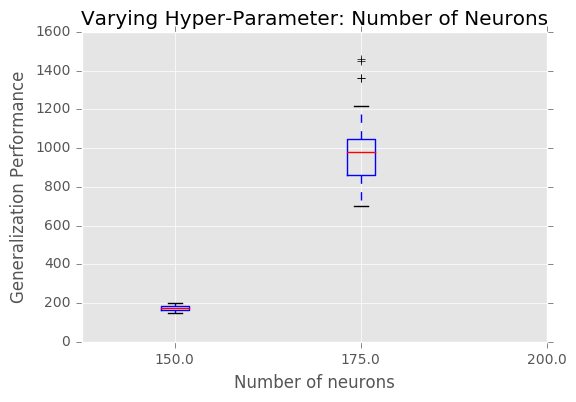

In [54]:
plt.boxplot([hidden_neurons,neuron_perf])
plt.title("Varying Hyper-Parameter: Number of Neurons")
plt.xlabel('Number of neurons')
plt.ylabel('Generalization Performance')
plt.xticks([1,2,3,4,5,6,7,8,9,10],hidden_neurons)
plt.figure()


In [57]:
costs = np.logspace(-3,1, num=3)
costs.sort()

In [59]:
cost_perf = []
for cost in costs:

        vals = {'n_hidden':neurons, 
                     'C':1e-2, 'epochs':15, 'eta':0.001, 
                     'alpha':0.0, 'decrease_const':1e-9, 'minibatches':200,
                     'shuffle':True,'random_state':1, 
                       'nonlinearity': "sigmoid"}
        for train_indices, test_indices in cv_object.split(X,y): 
                    print("---------------------------------")

                    X_train = (X[train_indices])
                    y_train = y[train_indices]

                    X_test = (X[test_indices])
                    y_test = y[test_indices]
                    
                    nn_long_sigmoid = TLPGaussianInitial(**vals)

                    #%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
                    %time nn_long_sigmoid.fit(X_train, y_train, print_progress=1)
                    y_hat = nn_long_sigmoid.predict(X_test) # get test set precitions

                    # now let's get the accuracy and confusion matrix for this iterations of training/testing
                    acc = mt.accuracy_score(y_test,y_hat+1)
            #         lr_clf_accuracies.append(acc)
            #         cost_accuracies.append([acc])

                    conf = mt.confusion_matrix(y_test,y_hat+1)
        #             print(vals)
#                     print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")
#                     plt.show()
                    print("confusion matrix\n",conf)
                    score = get_confusion_costTot(conf, cost_matrix)
                    print("Weighted Confusion Matrix Score: ", score)
                    cost_perf.append(score)



/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.56 s, sys: 112 ms, total: 6.67 s
Wall time: 1.69 s
confusion matrix
 [[ 0  0 14  0  0]
 [ 0  0 18  0  0]
 [ 0  0 25  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  721
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.78 s, sys: 175 ms, total: 6.95 s
Wall time: 1.78 s
confusion matrix
 [[ 0  0  3 11  0]
 [ 0  0  5 13  0]
 [ 0  0  3 22  0]
 [ 0  0  0 24  0]
 [ 0  0  2 20  0]]
Weighted Confusion Matrix Score:  991
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.64 s, sys: 143 ms, total: 6.78 s
Wall time: 1.72 s
confusion matrix
 [[ 0  0  7  0  6]
 [ 0  0  9  0  9]
 [ 0  0  8  0 17]
 [ 0  0 10  0 14]
 [ 0  0  7  0 15]]
Weighted Confusion Matrix Score:  1202
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.65 s, sys: 144 ms, total: 6.8 s
Wall time: 1.73 s
confusion matrix
 [[ 0  1  0 12  0]
 [ 0  1  0 17  0]
 [ 0  0  1 23  0]
 [ 0  0  0 24  0]
 [ 0  0  0 22  0]]
Weighted Confusion Matrix Score:  1001
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.46 s, sys: 150 ms, total: 6.61 s
Wall time: 1.68 s
confusion matrix
 [[ 0  0  5  1  7]
 [ 0  0  5  3 10]
 [ 0  0  8  6 10]
 [ 0  0  2  2 20]
 [ 0  0  1  0 21]]
Weighted Confusion Matrix Score:  1287
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.25 s, sys: 90.9 ms, total: 6.34 s
Wall time: 1.59 s
confusion matrix
 [[ 0  9  0  2  2]
 [ 0  9  0  1  8]
 [ 0 10  0  2 12]
 [ 0  9  0  0 15]
 [ 0  1  0  0 21]]
Weighted Confusion Matrix Score:  1186
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.16 s, sys: 84.2 ms, total: 6.25 s
Wall time: 1.57 s
confusion matrix
 [[ 0  0 12  1  0]
 [ 0  0 17  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  2  0]
 [ 0  0 21  1  0]]
Weighted Confusion Matrix Score:  712
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.2 s, sys: 107 ms, total: 6.3 s
Wall time: 1.59 s
confusion matrix
 [[ 0  0  5  8  0]
 [ 0  0 11  6  0]
 [ 0  0 11 13  0]
 [ 0  0  9 15  0]
 [ 0  0  6 16  0]]
Weighted Confusion Matrix Score:  874
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.15 s, sys: 86.1 ms, total: 6.23 s
Wall time: 1.57 s
confusion matrix
 [[ 0  1  0 12  0]
 [ 0  0  0 17  0]
 [ 0  1  1 22  0]
 [ 0  1  0 22  0]
 [ 0  0  0 22  0]]
Weighted Confusion Matrix Score:  978
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.07 s, sys: 78.3 ms, total: 6.15 s
Wall time: 1.54 s
confusion matrix
 [[ 0  0 11  0  2]
 [ 0  0 14  0  3]
 [ 0  0 18  0  6]
 [ 0  0 18  0  5]
 [ 0  0  9  0 12]]
Weighted Confusion Matrix Score:  910
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.69 s, sys: 149 ms, total: 6.84 s
Wall time: 1.73 s
confusion matrix
 [[ 0  0 12  0  2]
 [ 0  0 13  0  5]
 [ 0  0 16  0  9]
 [ 0  0 14  0 10]
 [ 0  0  6  0 16]]
Weighted Confusion Matrix Score:  1057
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 7.07 s, sys: 187 ms, total: 7.26 s
Wall time: 1.87 s
confusion matrix
 [[ 0  8  0  6  0]
 [ 0  8  1  9  0]
 [ 0  6  0 19  0]
 [ 0  5  0 17  2]
 [ 0  4  0 15  3]]
Weighted Confusion Matrix Score:  959
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.74 s, sys: 144 ms, total: 6.88 s
Wall time: 1.74 s
confusion matrix
 [[ 0  1  1  0 11]
 [ 0  1  3  0 14]
 [ 0  0  1  0 24]
 [ 0  0  3  0 21]
 [ 0  0  0  0 22]]
Weighted Confusion Matrix Score:  1450
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.69 s, sys: 149 ms, total: 6.84 s
Wall time: 1.73 s
confusion matrix
 [[ 0  0  5  0  8]
 [ 0  0  5  0 13]
 [ 0  0  4  0 20]
 [ 0  0  3  0 21]
 [ 0  0  2  0 20]]
Weighted Confusion Matrix Score:  1363
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.7 s, sys: 137 ms, total: 6.84 s
Wall time: 1.73 s
confusion matrix
 [[ 0  0 10  0  3]
 [ 0  0 10  0  8]
 [ 0  0 11  0 13]
 [ 0  0 17  0  7]
 [ 0  0 10  0 12]]
Weighted Confusion Matrix Score:  1051
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.99 s, sys: 165 ms, total: 7.16 s
Wall time: 1.82 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 17  1  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 20  2  0]]
Weighted Confusion Matrix Score:  716
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.84 s, sys: 182 ms, total: 7.03 s
Wall time: 1.79 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 17  0  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  700
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.86 s, sys: 151 ms, total: 7.01 s
Wall time: 1.8 s
confusion matrix
 [[ 0  8  2  3  0]
 [ 0  9  2  5  1]
 [ 0 16  2  6  0]
 [ 0 13  1 10  0]
 [ 0  8  5  8  1]]
Weighted Confusion Matrix Score:  812
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.84 s, sys: 135 ms, total: 6.97 s
Wall time: 1.76 s
confusion matrix
 [[ 0  0  4  9  0]
 [ 0  0  4 13  0]
 [ 0  0  5 19  0]
 [ 0  0  1 22  0]
 [ 0  0  2 20  0]]
Weighted Confusion Matrix Score:  942
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.76 s, sys: 130 ms, total: 6.89 s
Wall time: 1.74 s
confusion matrix
 [[ 0  1 12  0  0]
 [ 0  0 17  0  0]
 [ 0  0 20  4  0]
 [ 0  1 20  2  0]
 [ 0  1 16  4  0]]
Weighted Confusion Matrix Score:  716
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 7.36 s, sys: 159 ms, total: 7.52 s
Wall time: 1.9 s
confusion matrix
 [[ 0  0 12  0  2]
 [ 0  0 13  0  5]
 [ 0  0 16  0  9]
 [ 0  0 14  0 10]
 [ 0  0  6  0 16]]
Weighted Confusion Matrix Score:  1057
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 7.08 s, sys: 174 ms, total: 7.25 s
Wall time: 1.84 s
confusion matrix
 [[ 0  8  0  6  0]
 [ 0  8  1  9  0]
 [ 0  6  0 19  0]
 [ 0  5  0 17  2]
 [ 0  4  0 15  3]]
Weighted Confusion Matrix Score:  959
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 7.14 s, sys: 159 ms, total: 7.3 s
Wall time: 1.85 s
confusion matrix
 [[ 0  1  1  0 11]
 [ 0  1  3  0 14]
 [ 0  0  1  0 24]
 [ 0  0  3  0 21]
 [ 0  0  0  0 22]]
Weighted Confusion Matrix Score:  1450
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.8 s, sys: 116 ms, total: 6.92 s
Wall time: 1.74 s
confusion matrix
 [[ 0  0  5  0  8]
 [ 0  0  5  0 13]
 [ 0  0  4  0 20]
 [ 0  0  3  0 21]
 [ 0  0  2  0 20]]
Weighted Confusion Matrix Score:  1363
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 6.9 s, sys: 140 ms, total: 7.04 s
Wall time: 1.79 s
confusion matrix
 [[ 0  0 10  0  3]
 [ 0  0 10  0  8]
 [ 0  0 11  0 13]
 [ 0  0 17  0  7]
 [ 0  0 10  0 12]]
Weighted Confusion Matrix Score:  1051
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 7.09 s, sys: 148 ms, total: 7.24 s
Wall time: 1.83 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 17  1  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 20  2  0]]
Weighted Confusion Matrix Score:  716
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 7.39 s, sys: 200 ms, total: 7.59 s
Wall time: 1.94 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 17  0  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  700
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 7.04 s, sys: 161 ms, total: 7.2 s
Wall time: 1.82 s
confusion matrix
 [[ 0  8  2  3  0]
 [ 0  9  2  5  1]
 [ 0 16  2  6  0]
 [ 0 13  1 10  0]
 [ 0  8  5  8  1]]
Weighted Confusion Matrix Score:  812
---------------------------------


Epoch: 15/15/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Epoch: 2/15

CPU times: user 7.13 s, sys: 146 ms, total: 7.27 s
Wall time: 1.87 s
confusion matrix
 [[ 0  0  4  9  0]
 [ 0  0  4 13  0]
 [ 0  0  5 19  0]
 [ 0  0  1 22  0]
 [ 0  0  2 20  0]]
Weighted Confusion Matrix Score:  942
---------------------------------


Epoch: 15/15

CPU times: user 6.77 s, sys: 126 ms, total: 6.89 s
Wall time: 1.77 s
confusion matrix
 [[ 0  1 12  0  0]
 [ 0  0 17  0  0]
 [ 0  0 20  4  0]
 [ 0  1 20  2  0]
 [ 0  1 16  4  0]]
Weighted Confusion Matrix Score:  716


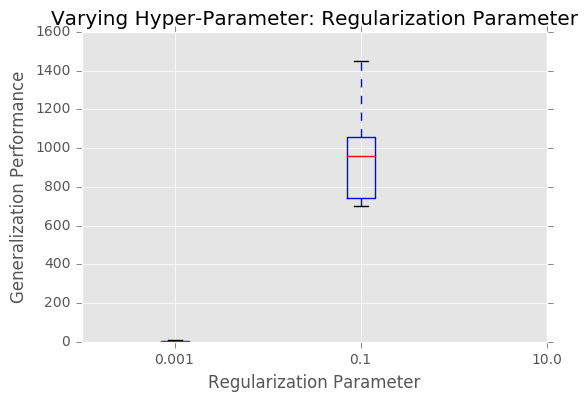

In [61]:
plt.boxplot([costs,cost_perf])
plt.title("Varying Hyper-Parameter: Regularization Parameter")
plt.xlabel('Regularization Parameter')
plt.ylabel('Generalization Performance')
plt.xticks([1,2,3,4,5,6,7,8,9,10],costs)
plt.figure()


## Comparing our MLP Implementation with that of Scikit Learn  


In [51]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':15, 'eta':0.001, 
         'alpha':0.0, 'decrease_const':1e-9, 'minibatches':200,
         'shuffle':True,'random_state':1, 
           'nonlinearity': "sigmoid"}
custom_performances = []
custom_times = []
custom_mem = []
sk_performances = []
sk_times = []
sk_mem = []
for train_indices, test_indices in cv_object.split(X,y): 
            
            # I will create new variables here so that it is more obvious what 
            # the code is doing (you can compact this syntax and avoid duplicating memory,
            # but it makes this code less readable)
            X_train = (X[train_indices])
            y_train = y[train_indices]

            X_test = (X[test_indices])
            y_test = y[test_indices]

            nn_long_sigmoid = TLPGaussianInitialQuad(**vals)
           

            #%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
            st = time.time()

            mem = memory_usage((nn_long_sigmoid.fit,(X_train,y_train))) # train object
            t = (time.time() -st)
            custom_times.append(t)
            custom_mem.append(mem[0])

            %time nn_long_sigmoid.fit(X_train, y_train, print_progress=1)
            y_hat = nn_long_sigmoid.predict(X_test) # get test set precitions

            # now let's get the accuracy and confusion matrix for this iterations of training/testing
            acc = mt.accuracy_score(y_test,y_hat+1)
    #         lr_clf_accuracies.append(acc)
    #         cost_accuracies.append([acc])

            conf = mt.confusion_matrix(y_test,y_hat+1)
#             print(vals)
#                     print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")
#                     plt.show()
            print("confusion matrix\n",conf)
            score = get_confusion_costTot(conf, cost_matrix)
            print("Weighted Confusion Matrix Score: ", score)
            custom_performances.append(score)
            
            clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                        activation='relu', # type of non-linearity, every layer
                        solver='sgd', 
                        alpha=1e-4, # L2 penalty
                        batch_size= 'auto', # min of 200, num_samples
                        learning_rate='constant', # adapt learning? only for sgd
                        learning_rate_init=0.1, # only SGD
                        power_t=0.0,    # only SGD with inverse scaling of learning rate
                        max_iter=75, # stopping criteria
                        shuffle=True, 
                        random_state=1, 
                        tol=0, # for stopping
                        verbose=False, 
                        warm_start=False, 
                        momentum=0.9, # only SGD
                        nesterovs_momentum=False, # only SGD
                        early_stopping=False, 
                        validation_fraction=0.0, # only if early_stop is true
                        beta_1=0.9, # adam decay rate of moment
                        beta_2=0.999, # adam decay rate of moment
                        epsilon=1e-08) # adam numerical stabilizer
            
            print("SCIKIT*****")
            
            st = time.time()

            mem = memory_usage((clf.fit,(X_train,y_train))) # train object
            t = (time.time() -st)
            sk_times.append(t)
            sk_mem.append(mem[0])
#             %time clf.fit(X_train,y_train)
            yhat = clf.predict(X_test)
            print('Validation Acc:',accuracy_score(yhat,y_test))
            conf = mt.confusion_matrix(y_test,y_hat)
                    #             print(vals)
            #                     print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")
            #                     plt.show()
            print("confusion matrix\n",conf)
            score = get_confusion_costTot(conf, cost_matrix)
            print("Weighted Confusion Matrix Score: ", score)
            sk_performances.append(score)


Epoch: 15/15

CPU times: user 2.94 s, sys: 37.9 ms, total: 2.98 s
Wall time: 753 ms
confusion matrix
 [[ 0  0  0 14  0]
 [ 0  0  0 18  0]
 [ 0  0  0 25  0]
 [ 0  0  0 24  0]
 [ 0  0  0 22  0]]
Weighted Confusion Matrix Score:  1030
SCIKIT*****
Validation Acc: 0.242718446602
confusion matrix
 [[ 0  0 14  0  0]
 [ 0  0 18  0  0]
 [ 0  0 25  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  721


Epoch: 15/15

CPU times: user 2.94 s, sys: 57.6 ms, total: 2.99 s
Wall time: 755 ms
confusion matrix
 [[ 0  0  9  5  0]
 [ 0  0 14  4  0]
 [ 0  0 20  5  0]
 [ 0  0 19  5  0]
 [ 0  0 17  5  0]]
Weighted Confusion Matrix Score:  793
SCIKIT*****
Validation Acc: 0.242718446602
confusion matrix
 [[ 0  9  5  0  0]
 [ 0 14  4  0  0]
 [ 0 20  5  0  0]
 [ 0 19  5  0  0]
 [ 0 17  5  0  0]]
Weighted Confusion Matrix Score:  721


Epoch: 15/15

CPU times: user 2.92 s, sys: 59 ms, total: 2.98 s
Wall time: 752 ms
confusion matrix
 [[ 0  0  1 12  0]
 [ 0  0  4 14  0]
 [ 0  0  3 22  0]
 [ 0  0  5 19  0]
 [ 0  0  4 18  0]]
Weighted Confusion Matrix Score:  969
SCIKIT*****
Validation Acc: 0.235294117647
confusion matrix
 [[ 0  1 12  0  0]
 [ 0  4 14  0  0]
 [ 0  3 22  0  0]
 [ 0  5 19  0  0]
 [ 0  4 18  0  0]]
Weighted Confusion Matrix Score:  714


Epoch: 15/15

CPU times: user 3.11 s, sys: 64.7 ms, total: 3.17 s
Wall time: 804 ms
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 18  0  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  707
SCIKIT*****
Validation Acc: 0.237623762376
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 18  0  0  0]
 [ 0 24  0  0  0]
 [ 0 24  0  0  0]
 [ 0 22  0  0  0]]
Weighted Confusion Matrix Score:  707


Epoch: 15/15

CPU times: user 3.16 s, sys: 66.1 ms, total: 3.22 s
Wall time: 816 ms
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 18  0  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  707
SCIKIT*****
Validation Acc: 0.237623762376
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 18  0  0  0]
 [ 0 24  0  0  0]
 [ 0 24  0  0  0]
 [ 0 22  0  0  0]]
Weighted Confusion Matrix Score:  707


Epoch: 15/15

CPU times: user 3.02 s, sys: 78.6 ms, total: 3.1 s
Wall time: 790 ms
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 18  0  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  707
SCIKIT*****
Validation Acc: 0.237623762376
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 18  0  0  0]
 [ 0 24  0  0  0]
 [ 0 24  0  0  0]
 [ 0 22  0  0  0]]
Weighted Confusion Matrix Score:  707


Epoch: 15/15

CPU times: user 3.28 s, sys: 89.3 ms, total: 3.37 s
Wall time: 861 ms
confusion matrix
 [[ 0  0  1  5  7]
 [ 0  0  0  8  9]
 [ 0  0  1 15  8]
 [ 0  0  0 11 13]
 [ 0  0  1  6 15]]
Weighted Confusion Matrix Score:  1251
SCIKIT*****
Validation Acc: 0.24
confusion matrix
 [[ 0  1  5  7  0]
 [ 0  0  8  9  0]
 [ 0  1 15  8  0]
 [ 0  0 11 13  0]
 [ 0  1  6 15  0]]
Weighted Confusion Matrix Score:  856


Epoch: 15/15

CPU times: user 2.91 s, sys: 49.6 ms, total: 2.96 s
Wall time: 746 ms
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 17  0  0]
 [ 0  0 24  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  0  0]]
Weighted Confusion Matrix Score:  700
SCIKIT*****
Validation Acc: 0.24
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 17  0  0  0]
 [ 0 24  0  0  0]
 [ 0 24  0  0  0]
 [ 0 22  0  0  0]]
Weighted Confusion Matrix Score:  700


Epoch: 15/15

CPU times: user 2.99 s, sys: 54.9 ms, total: 3.04 s
Wall time: 769 ms
confusion matrix
 [[ 0  0  5  7  1]
 [ 0  0 12  5  0]
 [ 0  0  9 14  1]
 [ 0  0  9 11  3]
 [ 0  0  3 13  6]]
Weighted Confusion Matrix Score:  931
SCIKIT*****
Validation Acc: 0.242424242424
confusion matrix
 [[ 0  5  7  1  0]
 [ 0 12  5  0  0]
 [ 0  9 14  1  0]
 [ 0  9 11  3  0]
 [ 0  3 13  6  0]]
Weighted Confusion Matrix Score:  726


Epoch: 15/15

CPU times: user 3.06 s, sys: 73.3 ms, total: 3.13 s
Wall time: 795 ms
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 17  0  0]
 [ 0  0 24  0  0]
 [ 0  0 22  1  0]
 [ 0  0 21  0  0]]
Weighted Confusion Matrix Score:  689
SCIKIT*****
Validation Acc: 0.244897959184
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 17  0  0  0]
 [ 0 24  0  0  0]
 [ 0 22  1  0  0]
 [ 0 21  0  0  0]]
Weighted Confusion Matrix Score:  686


## Comparing Implementations in terms of Generalization Performance, Computation Time, and Memory Usage

In [ ]:
print(sk_performances)
print(custom_performances)

2099.7478008270264


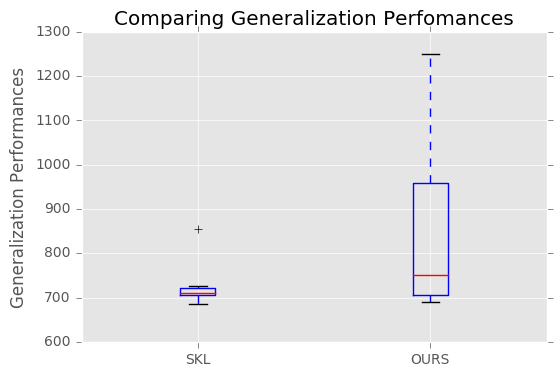

In [52]:
plt.boxplot([sk_performances,custom_performances])
plt.title("Comparing Generalization Perfomances")
plt.xlabel('')
plt.ylabel('Generalization Performances')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()
print((time.time() -st)*100)
# ax = fig.add_subplot(111)


In [ ]:
plt.boxplot([sk_times,custom_times])
plt.title("Comparing Computation Times")
plt.xlabel('Implementation')
plt.ylabel('Training Time (seconds) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

In [ ]:
plt.boxplot([sk_mem,custom_mem])
plt.title("Comparing Memory ")
plt.xlabel('Implementation ')
plt.ylabel('Memory Usage (mb) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()